In [7]:
import json 
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from collections import defaultdict

import json 
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from collections import defaultdict
import sys

sys.path.insert(0, '../')


from trust.pagerank import PersonalizedPageRank, PersonalizedPageRankNx
from trust.hitting_time import PersonalizedHittingTime
from trust.maxflow_based import MaxFlow, BarterCast

from trust.seed_choice import get_seed_rep_max


# MakerDAO reputation evolution

In [2]:
from networkx.readwrite import json_graph
import json

l = 153
G_t  = []

for i in range(l):
    with open('../datasets/sourcecred/makerDao_work/wg'+str(i)+'.json', 'r') as f:
        d = json.loads(f.read())
        G = json_graph.node_link_graph(d)
        # Normalize the weights to [1, inf]
        for e in list(G.edges()):
            G[e[0]][e[1]]['weight'] *= 4
        G_t.append(G)


In [3]:
id_to_user = {}
with open('../datasets/sourcecred/md_users.txt', 'r') as outfile1:
    vals = outfile1.read()
    for v in vals.split('\n'):
        vals_s = v.split(',')
        if len(vals_s) == 2:
            id_to_user[vals_s[0]] = vals_s[1]    

# Reputation calculation 

1. We assume initial period of bootstrap: T weeks. In the boostrap weeks the seeds are chosen randomly in the network. 
2. Reputation is calculated as a random walk-based metric run from the seed node. 
 - We take into account the weight of the edges. 
 - Random walks probability are calculated based on the weights. 

3. On the next rounds the seed is chosed based on previous rounds. 


In [424]:
def normalize(rep_vals):
    """Normalize reputation values to [0, 1]."""
    max_rep = sum(rep_vals.values())
    new_vals = {}
    for v in rep_vals:
        new_vals[v] = rep_vals[v] / max_rep
    return new_vals

def build_aux_graph(G, seed_node):
    H = G.copy()
    for e in G.edges():
        if e[0] != seed_node:
            H[e[0]][e[1]]['weight'] = G[e[0]][e[1]]['weight'] / G.out_degree(e[0], weight='weight')
    return H

def decay_aux_graph(G, seed_node, p=0.85):
    lvl = 0
    cur_s = {seed_node}
    next_s = set()

    for f,t,_ in nx.edge_bfs(G, seed_node, orientation='original'):
        if f in cur_s:
            next_s.add(t)
            G[f][t]['weight'] *= p**lvl
        else:
            # Start of new level 
            lvl += 1
            cur_s = next_s.copy()
            next_s = {t}
            G[f][t]['weight'] *= p**lvl
    return G

def seed_flow_graph(G, seed_node, flow_node):
    H = G.copy()
    for e2 in G[seed_node]:
        if e2 != flow_node:
            H.remove_edge(seed_node, e2)
    return H


def aux_max_flow(G, seed_node, decay_p = 0.85):
    T = build_aux_graph(G, seed_node)
    T = decay_aux_graph(T, seed_node, decay_p)
    new_vals = {}

    for i in T.nodes():
        if i != seed_node:
            new_vals[i] = nx.maximum_flow_value(T, seed_node, i, capacity='weight')
    return new_vals

    #for e in T[seed_node]:
    #    H = seed_flow_graph(T, seed_node, e)
    #    f_w = H[seed_node][e]['weight']
    #    rep_vals[e] += f_w 
    

def simple_maxflow(G, seed_node, rep_vals):
    for i in G.nodes():
        if i != seed_node:
            rep_vals[i] += nx.maximum_flow_value(G, seed_node, i, capacity='weight')


def simple_pht(G, seed_node, rep_vals, decay_p: float, use_weight: bool = True):
    pht = PersonalizedHittingTime(G, seed_node, reset_probability=1-decay_p)
    weight_mult = G.out_degree(seed_node, weight='weight') if use_weight else 1.0
    for i in G.nodes():
        if i != seed_node:
            rep_vals[i] += weight_mult * pht.compute(seed_node, i)


def simple_ppr(G, seed_node, rep_vals, decay_p: float, use_weight: bool = True):
    pht = PersonalizedPageRank(G, seed_node, reset_probability=1-decay_p)
    weight_mult = G.out_degree(seed_node, weight='weight') if use_weight else 1.0
    for i in G.nodes():
        if i != seed_node:
            rep_vals[i] += weight_mult *  pht.compute(seed_node, i)


# Personalized PageRank 
# Personalized Hitting Time 
# Personalized MaxFlow
# MeritRank


def pick_seeds(new_seeds, num_seeds):
    cur_seeds = []
    selected_seeds = 0
    while selected_seeds < num_seeds:
        for s in new_seeds:
            if s in G and G.out_degree(s) > 0:
                cur_seeds.append(s)
                selected_seeds += 1
                if selected_seeds == num_seeds:
                    return cur_seeds
        if selected_seeds != num_seeds:
            print('Cannot find enough seeds!')
            print(new_seeds)
            return None
    
def agg_rep_update(G: nx.Graph, seed_node: int, rep_alg, **rep_params):
    """Update reputation values based on the accumulated reputation."""
    new_rep = {}
    rep = rep_alg(G, seed_node, **rep_params)
    for v_node in G.nodes():
        if v_node != seed_node:
            new_rep[v_node] = rep.compute(seed_node, v_node)
    return new_rep

def aux_rep(G, s, decay_p = 0.85, rep_func = 'ppr'):
    new_rep = defaultdict(float)
    for k in G[s]:
        f_w = G[s][k]['weight'] / G.out_degree(s, weight='weight')
        H = seed_flow_graph(G, s, k)
        if rep_func == 'ppr':
            R = PersonalizedPageRank(H, s, number_random_walks = 1000, reset_probability =  1- decay_p)
        for i in H.nodes():
            if i != s:
                new_rep[i] += f_w * R.compute(s, i)
    return new_rep


In [459]:
G = G_t[10].copy()

In [460]:
H = build_aux_graph(G, 0)
H = decay_aux_graph(H, s, 0.85)

In [462]:
aux_max_flow(G, s, 0.85)

{140401: 0.748,
 142117: 0.7959336219336218,
 140514: 0.6994864127100968,
 140539: 0,
 140752: 0,
 140557: 0,
 141798: 0.8974358974358974,
 141586: 0.8974358974358974,
 141747: 0,
 140904: 0.10793650793650793,
 141429: 0.12041666666666664,
 141701: 0.2564102564102564,
 142079: 0,
 141735: 0,
 141389: 0.7645517640254481,
 141086: 0.28151147098515517,
 140957: 0.2229807692307692,
 141821: 0,
 141993: 0.05128205128205128,
 142181: 0,
 142271: 0,
 142378: 0,
 141911: 0,
 141824: 0.09444444444444444,
 141957: 0.18888888888888888,
 141995: 0.040138888888888884,
 140452: 0.05128205128205128,
 141377: 0.06568181818181817}

In [461]:
for i in H.nodes():
    if i != s:
        print(nx.maximum_flow_value(H, s, i, capacity='weight'))

0.748
0.7959336219336218
0.6994864127100968
0
0
0
0.8974358974358974
0.8974358974358974
0
0.10793650793650793
0.12041666666666664
0.2564102564102564
0
0
0.7645517640254481
0.28151147098515517
0.2229807692307692
0
0.05128205128205128
0
0
0
0
0.09444444444444444
0.18888888888888888
0.040138888888888884
0.05128205128205128
0.06568181818181817


In [458]:
for i in H.nodes():
    if i != s:
        print(nx.maximum_flow_value(H, s, i, capacity='weight'))

0.06451612903225806
0.13970348647768002
0.12903225806451613
0.1935483870967742
0.467741935483871
0.01717171717171717
0.16129032258064516
0
0.3064516129032258
0.16129032258064516
0.11603128054740958
0.03434343434343434
0
0
0.01717171717171717


In [453]:
H.in_degree(weight='weight')

InDegreeView({140557: 0.06451612903225806, 140799: 5.421095571095571, 140860: 1.0328796651377297, 141821: 0.12903225806451613, 141701: 0.1935483870967742, 141798: 0.596653633105246, 141362: 0.01717171717171717, 142117: 3.4259408602150536, 141747: 0, 141957: 1.3447214076246334, 142271: 0.44689393939393934, 141429: 0.11603128054740958, 141520: 0.03434343434343434, 142258: 0, 140591: 0, 142176: 0.01717171717171717})

0.06451612903225806
0.13970348647768002
0.12903225806451613
0.1935483870967742
0.467741935483871
0.01717171717171717
0.16129032258064516
0
0.3064516129032258
0.16129032258064516
0.11603128054740958
0.03434343434343434
0
0
0.01717171717171717


0.467741935483871

In [386]:
G = G_t[0]
s = 140799
reps = dict()
R = PersonalizedHittingTime(G, s)

for t in G.nodes():
    if t != s:
        reps[t] = R.compute(s, t)
sorted(reps.items(), key=lambda x: x[1], reverse=True)[:10]

[(141798, 0.21531322505800465),
 (141701, 0.1665893271461717),
 (141957, 0.1308584686774942),
 (142117, 0.12529002320185614),
 (141821, 0.108584686774942),
 (140860, 0.0765661252900232),
 (140557, 0.06682134570765662),
 (141429, 0.06450116009280743),
 (142271, 0.032018561484918794),
 (141520, 0.005568445475638051)]

In [405]:
G = G_t[100]
vals = aux_max_flow(G, s, 0.85)

In [411]:
H = build_aux_graph(G, 0)

In [ ]:
normalize()

AtlasView({141573: {'weight': 20.5}, 141221: {'weight': 8}, 140655: {'weight': 4}, 140751: {'weight': 8}, 140402: {'weight': 4}, 140557: {'weight': 12}, 142258: {'weight': 8}, 142194: {'weight': 4}, 140397: {'weight': 18.0}, 141563: {'weight': 4}, 142378: {'weight': 4}, 141031: {'weight': 16}, 140506: {'weight': 4}, 142079: {'weight': 4}, 141389: {'weight': 8}, 140926: {'weight': 4}, 140571: {'weight': 8}, 141270: {'weight': 8}, 141924: {'weight': 4}, 142077: {'weight': 9.0}, 140452: {'weight': 8.0}, 141806: {'weight': 11.0}, 142292: {'weight': 4}, 140968: {'weight': 8.0}, 141297: {'weight': 1.0}, 141447: {'weight': 1.0}, 141824: {'weight': 2.0}, 141957: {'weight': 1.0}, 142188: {'weight': 1.0}, 142231: {'weight': 1.0}})

[(141031, 0.02531248264343893),
 (140587, 0.02531248264343893),
 (141945, 0.02531248264343893),
 (140571, 0.02531248264343893),
 (140888, 0.02531248264343893),
 (140397, 0.025312482643438928),
 (140926, 0.025312482643438928),
 (142077, 0.025312482643438928),
 (140557, 0.025312482643438924),
 (140904, 0.025312482643438924)]

In [423]:
H2[s]

AtlasView({141573: {'weight': 0.10379746835443038}, 141221: {'weight': 0.04050632911392405}, 140655: {'weight': 0.020253164556962026}, 140751: {'weight': 0.04050632911392405}, 140402: {'weight': 0.020253164556962026}, 140557: {'weight': 0.060759493670886074}, 142258: {'weight': 0.04050632911392405}, 142194: {'weight': 0.020253164556962026}, 140397: {'weight': 0.09113924050632911}, 141563: {'weight': 0.020253164556962026}, 142378: {'weight': 0.020253164556962026}, 141031: {'weight': 0.0810126582278481}, 140506: {'weight': 0.020253164556962026}, 142079: {'weight': 0.020253164556962026}, 141389: {'weight': 0.04050632911392405}, 140926: {'weight': 0.020253164556962026}, 140571: {'weight': 0.04050632911392405}, 141270: {'weight': 0.04050632911392405}, 141924: {'weight': 0.020253164556962026}, 142077: {'weight': 0.04556962025316456}, 140452: {'weight': 0.04050632911392405}, 141806: {'weight': 0.05569620253164557}, 142292: {'weight': 0.020253164556962026}, 140968: {'weight': 0.040506329113924

In [422]:
nx.maximum_flow_value(H2, s, 140397, capacity='weight')

0.9746835443037974

In [381]:
R = PersonalizedHittingTime(G_t[0], s)
R.compute(s, 141429)

0.07066974595842956

In [345]:
H.remove_edge(140799, 141429)

In [354]:
S = build_aux_graph(H, 0)

In [356]:
for e in nx.all_simple_edge_paths(H, s, 141429):
    for f,t in e:
        print(S[f][t]['weight'])
    print("-")


0.1
0.06060606060606061
-


In [359]:
R = PersonalizedHittingTime(H, s)
R.compute(s, 141429)

0.0071794871794871795

In [338]:
S[140799]

AtlasView({141821: {'weight': 0.125}, 141701: {'weight': 0.1875}, 141798: {'weight': 0.296875}, 141429: {'weight': 0.0625}, 140557: {'weight': 0.0625}, 140860: {'weight': 0.03125}, 141957: {'weight': 0.109375}, 142117: {'weight': 0.09375}, 0: {'weight': 0.03125}})

In [333]:
R = PersonalizedHittingTime(H, s)

In [334]:
R.compute(s, 141821)

0.1010194624652456

In [327]:
R.compute(s, 141821)

0.11617100371747212

In [75]:
s = 140799
old_reps = defaultdict(float)

G = G_t[10]
R = PersonalizedPageRank(G, s, number_random_walks = 1000, reset_probability = 0.15 )
for i in G.nodes():
    if i != s:
        old_reps[i] += R.compute(s, i)


In [459]:
# Choose the inital seeds 
G = G_t[0]
num_seeds = 3 

score  = {i: G.in_degree(i)*G.out_degree(i) for i in G.nodes()}
sorted_score = sorted(score.items(), key=lambda x: x[1], reverse=True)
initial_seeds = [k for k,_ in sorted_score[:num_seeds]]


seed_decay = True
seed_decay_p = 0.05
decay_p = 0.85


# Attack specification 
start_attack_w = 10
end_attack_w = 25
max_l = 50

num_attack_edges = 3
weight_attack_edges = 20
attacker_node = 140799

reward_per_w = 1000

# rep_algs = {'ppr': PersonalizedPageRank}
rep_algs = {'ppr': PersonalizedPageRank, 'pht': PersonalizedHittingTime, 'pmf': MaxFlow}
rep_args = {'ppr': {'number_random_walks': 1000, 'reset_probability': 1 - decay_p}, 
            'pht': {'number_random_walks': 1000, 'reset_probability': 1 - decay_p}, 
            'pmf': {},
            'aux_ppr': {'number_random_walks': 1000, 'reset_probability': 1 - decay_p}}



In [ ]:
rep_vals = {'ppr': defaultdict(float), 'pht': defaultdict(float), 'pmf': defaultdict(float)}
new_seeds = {'ppr': initial_seeds.copy(), 'pht': initial_seeds.copy(), 'pmf': initial_seeds.copy()}
cur_seeds = {}

H_t = [G_t[i].copy() for i in range(max_l)]

rewards = {'ppr': defaultdict(float), 'pht': defaultdict(float), 'pmf': defaultdict(float)}
used_rep = {'ppr': defaultdict(float), 'pht': defaultdict(float), 'pmf': defaultdict(float)}

syb_count = 0

for w in range(max_l):
    G = H_t[w]
    # # 1. Pick seeds for reputation calculation 
    for r_n in rep_algs.keys():
        cur_seeds[r_n] = pick_seeds(new_seeds[r_n], num_seeds)
    # 2. Insert Attack edges 
    # We mimic the attack edges as a real user - attacker_node
    if w == start_attack_w:
        for i in range(num_attack_edges):
            G.add_edge(attacker_node, attacker_node + i)
    # 3. Insert Sybil edges
    # 4. Update reputation
    for r_n in rep_algs.keys():
        for seed_node in cur_seeds[r_n]:    
            new_rep = agg_rep_update(G, seed_node, rep_algs[r_n], **rep_args[r_n])
            for k,v in new_rep.items():
                rep_vals[r_n][k] += v
            # 5. Optional seed punish
            if seed_decay:
                rep_vals[r_n][seed_node] *= seed_decay_p
        # 6. Choose new seeds: maximum reputation 
        new_seeds[r_n] = [k for k,_ in sorted(rep_vals[r_n].items(), key=lambda x: x[1], reverse=True)]
    # 7. Distribute the rewards 
    for r_n in rep_algs.keys():
        rep_sum = sum(rep_vals[r_n].values())
        for k,v in rep_vals[r_n].items():
            # rewards[r_n][k] += (v - used_rep[r_n][k]) * reward_per_w / num_seeds
            rewards[r_n][k] += (v / rep_sum) * reward_per_w 
            used_rep[r_n][k] = rep_vals[r_n][k]


In [309]:
for k,v in sorted([(k,v) for k,v in rep_vals.items() if v > 0], key=lambda x: x[1], reverse=True)[:20]:
    print(id_to_user.get(str(k)), k, v)

@equivrel 141519 278.46857668969506
@charlesstlouis 141362 264.04369184491486
@cyrus 141429 260.2216625786077
@monet-supply 141945 259.0170898990639
@MakerMan 140820 248.44388957587046
@LongForWisdom 140799 242.0987523853942
@rune 142141 231.22284262084898
@befitsandpiper 141280 224.82829238234388
@hexonaut 141627 223.0645502392742
@Jiecut 140714 214.67707788349355
@NikKunkel 140904 185.19765601607543
@Andy_McCall 140433 179.25429922875588
@Jtathmann 140738 177.46134333518057
@s_ben 142150 172.22139199975078
@cmooney 141389 167.04566945237724
@FourthStreet 140621 148.75027550285557
@hongbiao_li 141638 147.52744218686473
@Kurt_Barry 140773 138.0095615171009
@andytudhope 141231 132.17204047113324
@Spidomo 141054 125.94887234725405


In [463]:

attack_w = 10
num_syb = 5

attack_w = 20
max_l = 80

def add_sybil_path_region(G, attacker_node, total_syb, num_syb):
    G.add_edge(attacker_node, attacker_node*2 + total_syb, weight=attack_w)
    a = attacker_node*2 + total_syb
    for i in range(num_syb):
        G.add_edge(a + i, a + i + 1, weight=attack_w)
    return num_syb + 1

def add_sybil_cycle_region(G, attacker_node, total_syb, num_syb):
    for i in range(num_syb):
        a = attacker_node*2 + total_syb + i
        G.add_edge(attacker_node, a, weight=attack_w)
        G.add_edge(a, attacker_node, weight=attack_w)
    return num_syb

def add_sybil_parallel_region(G, attacker_node, total_syb, num_syb):
    a = attacker_node*2 + total_syb
    for i in range(num_syb):
        G.add_edge(attacker_node, a + i, weight=attack_w)
    return num_syb + 1


    

In [190]:
# Pre-run the reputation 

rep_vals = defaultdict(float)
seed_punish = False

G = G_t[0]
num_seeds = 3 

score  = {i: G.in_degree(i)*G.out_degree(i) for i in G.nodes()}
sorted_score = sorted(score.items(), key=lambda x: x[1], reverse=True)
initial_seeds = [k for k,_ in sorted_score[:num_seeds]]
new_seeds = initial_seeds.copy()

for w in range(40):
    cur_seeds = []
    selected_seeds = 0
    G = G_t[w].copy()
    # 1. Select seeds based on gained reputation 
    while selected_seeds < num_seeds:
        for s in new_seeds:
            if s in G:
                cur_seeds.append(s)
                selected_seeds += 1
                if selected_seeds == num_seeds:
                    break
        if selected_seeds != num_seeds:
            print('Cannot find enough seeds!')
            break
    # 2. Build auxiliary graph. Weights for indirect edges are change to proportional. 
    for seed_node in cur_seeds:
        # simple_maxflow(G, seed_node, rep_vals,)
        # simple_ppr(G, seed_node, rep_vals, decay_p = decay_p, use_weight= False)
        simple_pht(G, seed_node, rep_vals, decay_p = decay_p, use_weight=False)
        # aux_max_flow(G, seed_node, rep_vals, decay_p = decay_p)
        # 3. Seed punish
        if seed_punish:
            intro_rep = G.out_degree(seed_node, weight='weight')
            rep_vals[seed_node] -= intro_rep * seed_decay
            rep_vals[seed_node] = max(rep_vals[seed_node], 0)

    new_seeds = sorted(rep_vals.items(), key=lambda x: x[1], reverse=True)
    new_seeds = [k for k,_ in new_seeds]


In [ ]:
seeds =  new_seeds[:10]

In [464]:
import pandas as pd
df = pd.DataFrame(columns=['active', 'passive', 'num_syb', 'weeks', 'decay_p'])

In [465]:
rep_vals = defaultdict(float)
old_rep_vals = []

num_seeds = 3

attacker_node = new_seeds[0]

seed_decay = 0.1
seed_punish = False
attack_w = 20
syb_rep_gain = {}

contrib_decay_w = 8 # 2 mounts 
contrib_decay_val = 0
N = 30

for decay_p in [0.4, 0.6, 0.8]:
    for num_syb in [30, 20, 15, 10, 5, 4, 3, 2, 1, 0]:
        for total_weeks in range(1, 10):
            total_syb = 0
            rep_vals = defaultdict(float)
            new_seeds = seeds[:num_seeds]
            for w in range(40, 40 + total_weeks):
                G = G_t[w].copy()
                cur_seeds = []
                selected_seeds = 0
                # 1. Select seeds based on gained reputation 
                while selected_seeds < num_seeds:
                    for s in new_seeds:
                        if s in G:
                            cur_seeds.append(s)
                            selected_seeds += 1
                            if selected_seeds == num_seeds:
                                break
                    if selected_seeds != num_seeds:
                        print('Cannot find enough seeds!')
                        break
                if w >= attack_w and num_syb > 0:
                    total_syb += add_sybil_parallel_region(G, attacker_node, total_syb, num_syb)
                
                # 2. Build auxiliary graph. Weights for indirect edges are change to proportional. 
                for seed_node in cur_seeds:
                    # simple_maxflow(G, seed_node, rep_vals,)
                    simple_ppr(G, seed_node, rep_vals, decay_p = decay_p, use_weight= False)
                    # simple_pht(G, seed_node, rep_vals, decay_p = decay_p, use_weight=False)
                    # aux_max_flow(G, seed_node, rep_vals, decay_p = decay_p)
                    # 3. Seed punish
                    if seed_punish:
                        intro_rep = G.out_degree(seed_node, weight='weight')
                        rep_vals[seed_node] -= intro_rep * seed_decay
                        rep_vals[seed_node] = max(rep_vals[seed_node], 0)
                
                #old_rep_vals.append(rep_vals.copy())
                #if len(old_rep_vals) == contrib_decay_w:
                #    old_reps = old_rep_vals.pop(0)
                #    for k,v in old_reps.items():
                #        rep_vals[k] -= v * contrib_decay_val
                
                # Choose new seeds
                new_seeds = sorted(rep_vals.items(), key=lambda x: x[1], reverse=True)
                new_seeds = [k for k,_ in new_seeds]
            df = df.append({'active': sum([rep_vals[attacker_node*2 + i] for i in range(total_syb)]), 'passive':  rep_vals[attacker_node], 'num_syb': num_syb, 'weeks': total_weeks, 'decay_p': decay_p}, ignore_index=True)
            if num_syb % 5 == 0:
                print("Processed {} our of {}".format(num_syb, N))
    print('--- Finished {} ---'.format(decay_p))
        

Processed 30 our of 30
Processed 30 our of 30
Processed 30 our of 30
Processed 30 our of 30
Processed 30 our of 30
Processed 30 our of 30
Processed 30 our of 30
Processed 30 our of 30
Processed 30 our of 30
Processed 20 our of 30
Processed 20 our of 30
Processed 20 our of 30
Processed 20 our of 30
Processed 20 our of 30
Processed 20 our of 30
Processed 20 our of 30
Processed 20 our of 30
Processed 20 our of 30
Processed 15 our of 30
Processed 15 our of 30
Processed 15 our of 30
Processed 15 our of 30
Processed 15 our of 30
Processed 15 our of 30
Processed 15 our of 30
Processed 15 our of 30
Processed 15 our of 30
Processed 10 our of 30
Processed 10 our of 30
Processed 10 our of 30
Processed 10 our of 30
Processed 10 our of 30
Processed 10 our of 30
Processed 10 our of 30
Processed 10 our of 30
Processed 10 our of 30
Processed 5 our of 30
Processed 5 our of 30
Processed 5 our of 30
Processed 5 our of 30
Processed 5 our of 30
Processed 5 our of 30
Processed 5 our of 30
Processed 5 our of

In [466]:
df['gain'] = (df['active']) / df['passive']

In [249]:
df.to_csv('syb_rep_mf_seed.csv')

In [165]:
df.to_csv('sybil_rep_maxflow.csv')

In [474]:
df2 = df[df['weeks'] == 3]

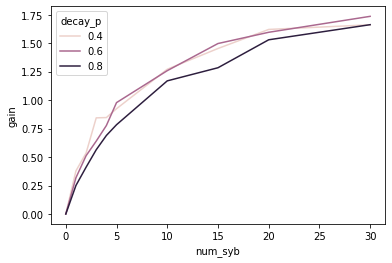

In [475]:
import seaborn as sns

g = sns.lineplot(x='num_syb', y='gain', data=df2, estimator='mean', ci=40, hue='decay_p', )
# g.set(yscale='log')
# g_results.set(xticks=sample_count)
#g_results.set(xticklabels=sample_count)


In [149]:
df.to_csv('sybil_rep_pht.csv')

<AxesSubplot:xlabel='num_syb', ylabel='gain'>

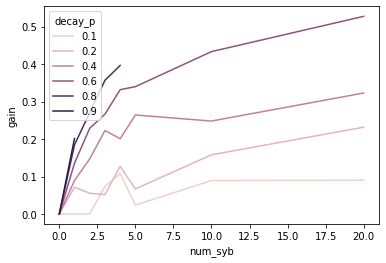

In [94]:
import seaborn as sns


sns.lineplot(x='num_syb', y='gain', data=df, estimator='mean', ci=90, hue='decay_p')

In [242]:
df.to_csv('syb_rep_gain.csv')

In [205]:
aux_maxflow_syil_gain = syb_rep_gain.copy()

In [211]:
aux_maxflow_syil_gain = {k // 2: v for k,v in aux_maxflow_syil_gain.items() if k > 0}

In [230]:
df

,active,passive,num_syb,weeks
0,130.197319,96.045241,20.0,2.0
1,128.877114,96.045241,10.0,2.0
2,113.124122,96.045241,5.0,2.0
3,102.190226,96.045241,4.0,2.0
4,89.603670,96.045241,3.0,2.0
5,74.262682,96.045241,2.0,2.0
6,55.375122,96.045241,1.0,2.0


In [214]:
df['weeks'] = 2

In [207]:
syb_rep_gain

{20: {'active': 66.11141080870743, 'passive': 6.770764067291448},
 10: {'active': 65.82400993004147, 'passive': 6.770764067291448},
 5: {'active': 62.394675983673466, 'passive': 6.770764067291448},
 4: {'active': 59.91568718367347, 'passive': 6.770764067291448},
 3: {'active': 55.78403918367347, 'passive': 6.770764067291448},
 2: {'active': 48.89795918367347, 'passive': 6.770764067291448},
 1: {'active': 38.46530612244898, 'passive': 6.770764067291448},
 0: {'active': 0, 'passive': 8.770764067291449}}

In [182]:
for k,v in sorted([(k,v) for k,v in rep_vals.items() if v > 0], key=lambda x: x[1], reverse=True)[:20]:
    print(id_to_user.get(str(k)), k, v)

@cyrus 141429 677.8381204404394
@MakerMan 140820 626.6017055538786
@LongForWisdom 140799 624.8525189450362
@psychonaut 142079 604.3843367125074
@rich.brown 142117 555.7543889274599
@Andy_McCall 140433 515.0330088528558
@hexonaut 141627 456.54731652306924
@monet-supply 141945 452.4988394004422
@jernejml 141701 450.87176886635757
@Mitote 140869 439.4233167089363
@Aaron_Bartsch 140397 405.1323140067299
@Planet_X 140957 389.576891467803
@Derek 140571 346.7002168662156
@charlesstlouis 141362 326.81607101214405
@swakya 142258 310.3290980640907
@NikKunkel 140904 304.90850543058804
@Kurt_Barry 140773 294.4290862187448
@rune 142141 294.11989937866036
@spin 142238 275.8673011922343
@latetot 141801 263.77512634017097


In [192]:
sum([rep_vals[attacker_node*2 + i] for i in range(total_syb)]) / rep_vals[attacker_node]

0.8461650498807798

In [279]:
# Make an attack 

a = 200000
x = np.random.choice([k for k,v in rep_vals.items() if v > 20], size=1)[0]
x = 142117

seed_decay = 0.1 # 30 % of introduced reputation is taken from seed reputation

AG_t = [G_t[w].copy() for w in range(l)]

# One attack edge 
AG_t[10].add_edge(x, a, weight=4)

num_syb = 0
# Sybil edges - arbitrary number of edges
for i in range(1, 1000):
    AG_t[10].add_edge(a, a+i, weight=40)
    num_syb += 1


for w in range(10, 20):
    G = AG_t[w]
    cur_seeds = []
    selected_seeds = 0
    # 1. Select seeds based on gained reputation 
    while selected_seeds < num_seeds:
        for s in new_seeds:
            if s in G:
                cur_seeds.append(s)
                selected_seeds += 1
                if selected_seeds == num_seeds:
                    break
        if selected_seeds != num_seeds:
            print('Cannot find enough seeds!')
            break
        
    for seed_node in cur_seeds:
        # 2. Build auxiliary graph. Weights for indirect edges are change to proportional. 
        aux_max_flow(G, seed_node, rep_vals, decay_p = 0.6)
        # Seed punish
        intro_rep = G.out_degree(seed_node, weight='weight')
        rep_vals[seed_node] -= intro_rep * seed_decay
        
    # Choose new seeds
    new_seeds = sorted(rep_vals.items(), key=lambda x: x[1], reverse=True)
    new_seeds = [k for k,_ in new_seeds]

    # Insert more Sybils 
    # Sybil edges - arbitrary number of edges
    for i in range(num_syb, num_syb+5):
        AG_t[w+1].add_edge(a, a+i, weight=40)
        num_syb += 1


In [280]:
sum(rep_vals[a+k] for k in range(num_syb)) 

34.012363636364256

11.11363636363636

In [281]:
for k,v in sorted([(k,v) for k,v in rep_vals.items() if v > 0], key=lambda x: x[1], reverse=True)[:20]:
    print(id_to_user.get(str(k)), k, v)

@cyrus 141429 340.6319968705102
@ginworkflow 141586 293.70073371547255
@LongForWisdom 140799 293.37674239172503
@jernejml 141701 276.1740297416319
@rich.brown 142117 275.13133118822606
@kwadrax 141798 258.6268484954899
@swakya 142258 240.57074524973547
@rune 142141 206.4096833569106
@Mitote 140869 195.85812254726426
@Adam_Skrodzki 140401 190.17167384574154
@Davidutro 140557 174.44913205082338
@Planet_X 140957 174.17657989205654
@ChrisBlec 140514 163.5106711901757
@NikKunkel 140904 150.54022818500184
@psychonaut 142079 133.3230621525939
@lix 141821 130.09576079733455
@iammeeoh 141648 123.31033704231137
@MicahZoltu 140860 111.3973094027242
@mmoossttaaffaa 141940 107.41048345732462
@tbone 142271 104.66126606959794


In [ ]:
# Attack scenario
# a) If top contributor decides to go rogue, and creates Sybils. 
# b) When you received feedback from the reputable nodes and exploit it.

# Passive attack - create links from Sybils to the attacker. 
# Active attack - receive cummulative reward due to transitivity of the reputation function. 




In [177]:
simple_maxflow_rep_vals = rep_vals.copy()

In [181]:
sum([1 for k,v in rep_vals.items() if v > 0])

1825

1960

In [190]:
for k,v in sorted([(k,v) for k,v in rep_vals.items() if v > 2000], key=lambda x: x[1], reverse=False)[:20]:
    print(id_to_user.get(str(k)), k, v)

@Planet_X 140957 2037.3787872708908
@twblack88 142317 2077.799772961968
@g_dip 141573 2103.060565973572
@NikKunkel 140904 2259.879547985243
@Derek 140571 2405.1808366698756
@Davidutro 140557 2478.3287952736314
@MakerMan 140820 2588.1384988800824
@Primoz 140968 2589.6205530525476
@juan 141754 2616.678489317537
@prose11 142077 2693.1246195289964
@psychonaut 142079 2735.3760933790286
@hexonaut 141627 2746.890190175418
@ElProgreso 140587 2788.5531612718905
@LongForWisdom 140799 2838.3929084499837
@ultraschuppi 142325 2845.150047063644
@SebVentures 141031 2861.2833242416664
@monet-supply 141945 2870.138716669133


## Adding Sybil agents at some time

- Attacker performs some work to receive positive feedback: 
  + Feedback from reputable nodes: like, reply, or references
- After receiveing some feedback: execute traitor attack  
  + Approve activity of Sybil bots
  + To increase the probability to receive more rewards during the distribution. 
- Two types of attacks: passive Sybil attack (manipulate to increase the reputation of attacker) and active Sybil attack (manipulate to increase reputation of Sybil bots). 


In [231]:
a = 200_000
num_syb = 0

rep_val = defaultdict(float)
norm_rep = {}
bootstrap_w = 8
H_t = [G_t[i].copy() for i in range(l)]

rep_val, norm_rep = rep(H_t, rep_val, norm_rep_val, 0, bootstrap_w, 10, seed_choice='random')
x = 140799
# np.random.choice(list(norm_rep.keys()), p=list(norm_rep.values()), replace=False)

print("Adding edge to ", x)
H_t[bootstrap_w].add_edge(x, a, weight=1)
rep_val[a] = 0
norm_rep[a] = 0

num_syb = 0
cur_w = bootstrap_w
while cur_w < l:
    # Insert Sybil edges:
    for k in range(10):
        num_syb += 1
        H_t[cur_w].add_edge(a, a+num_syb, weight=20)
        rep_val[a+num_syb] = 0
        norm_rep[a+num_syb] = 0
    # Further distribution seed_choice='random'
    rep_val, norm_rep = rep(H_t, rep_val, norm_rep, cur_w, cur_w + 1, 3)
    cur_w += 1
    
gain = 0
if norm_rep[a] != 0:
    gain = sum([norm_rep[a+i] for i in range(num_syb + 1)]) / norm_rep[a] 
print(gain)

Adding edge to  140799
55.79999999999997


In [190]:
val = {i:norm_rep[i] for i in range(a, a+num_syb)}
sorted(val.items(), key=lambda x: x[1], reverse=True)[:15]


[(201017, 0.00022707099064880656),
 (201019, 0.00022707099064880656),
 (200007, 0.0002064281733170969),
 (200001, 0.0001857853559853872),
 (200004, 0.0001857853559853872),
 (200010, 0.0001857853559853872),
 (200005, 0.0001651425386536775),
 (200008, 0.0001651425386536775),
 (201013, 0.0001651425386536775),
 (200009, 0.00014449972132196784),
 (201018, 0.00014449972132196784),
 (200002, 0.00012385690399025813),
 (200003, 0.00012385690399025813),
 (201011, 0.00012385690399025813),
 (201015, 0.00012385690399025813)]

## Reputation robustness 

The PHT reputation is vulnerable to active Sybil attack. 
As a result of creating one attack edge early with the most reputable node. 
The edge might be just a result of like from the most reputable node.

There are two countermeasures for this attack: 
1. Reputation decay -> The oppositve of the contribution graph. 
2. Seed selection: How many seeds and the selection (random, or Based on previous reputation).   


In [232]:
def update_rep(G_t, r, rep_vals, norm_vals, neg_rep):
    G = G_t[r]
    for s in G.nodes:
        rep_vals[s] -= neg_rep[s]
        if rep_vals[s] < 0:
            rep_vals[s] = 0 
    norm_vals = normalize(rep_vals)
    return rep_vals, norm_vals

def negative_rep(H_t, w, rep_val, norm_rep):
    neg_rep = defaultdict(float)
    neg_rep, _ = rep(H_t, neg_rep, {}, w, w+1, 10, seed_choice='random')
    return update_rep(H_t, w, rep_val, norm_rep, neg_rep)


In [308]:
def boostrap_week(H_t, start_week, end_week, number_of_seeds):
    """During bootstrap weeks all participants are equal.
    For reputation calculation - any seed can be used. 
    Return reputation values that contributed during this period. 
    """
    # Bootstrap weeks distribution
    rep_val = defaultdict(float)
    norm_rep = {}
    rep_val, norm_rep = rep(H_t, rep_val, norm_rep, 
        start_week, end_week, number_of_seeds, seed_choice='random')
    return rep_val, norm_rep





def experiment(with_decay=False):
    a = 200_000
    num_syb = 0

    rep_val = defaultdict(float)
    norm_rep = {}
    rewards_per_week = 1000 # USD per week for distribution 
    rewards = defaultdict(float)
    
    bootstrap_w = 8
    attack_w = 8
    syb_attack_num = 2

    # Reputation round distributions 
    num_seeds = 3

    H_t = [G_t[i].copy() for i in range(l)]
    RH_t = [H_t[i].reverse() for i in range(l)]

    
    
    # Insert Attack edges: 
    x = 140799
    H_t[bootstrap_w].add_edge(x, a, weight=1)
    rep_val[a] = 0
    norm_rep[a] = 0

    num_syb = 0
    cur_w = bootstrap_w
    while cur_w < l:
        # Insert Sybil edges:
        for k in range(1):
            num_syb += 1
            H_t[cur_w].add_edge(a, a+num_syb, weight=20)
            rep_val[a+num_syb] = 0
            norm_rep[a+num_syb] = 0

        # Distribute the rewards 
        if with_decay:
            # Run punishing walks
             
            # Decay on previous reputations
            r_w = cur_w - 2
            # 1. Reverse contribution graph 
            nrep_val = defaultdict(float)
            nnorm_rep = defaultdict(float)
            # nrep_val, nnorm_rep = rep(H_t, nrep_val, nnorm_rep, r_w, r_w + 1, 5, seed_choice='random', given_seeds=[140799])
            # 2. Update reputation
            for k in list(rep_val.keys()):
                rep_val[k] = max(rep_val[k] - nrep_val[k], 0) 
            norm_rep = normalize(rep_val)
        rep_val, norm_rep = rep(H_t, rep_val, norm_rep, cur_w, cur_w + 1, 3, given_seeds=[140799])
        
        # Distribute rewards using norm_rep
        for k, v in norm_rep.items():
            rewards[k] += rewards_per_week * v
            
        cur_w += 1
        
    gain = 0
    if rewards[a] != 0:
        gain = sum([rewards[a+i] for i in range(num_syb + 1)]) / rewards[a] 
    return gain
    

In [309]:
id_to_user['140799']

'@LongForWisdom'

In [310]:
no_decay_vals = [experiment() for _ in range(10)]
decay_vals = [experiment(with_decay=True) for _ in range(10)]

In [311]:
np.mean(decay_vals), np.mean(no_decay_vals)

(1.5833333333333335, 1.6473809523809522)